In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
print(tf.__version__)

2.8.0


In [27]:
# Load the data
df = pd.read_csv('Weekly_U.S.Diesel_Retail_Prices.csv', names=['Date', 'Price'], skiprows=1)  # skip the header row since we define our own headers
df.head()

,Date,Price
0,1994-03-21,1.106
1,1994-03-28,1.107
2,1994-04-04,1.109
3,1994-04-11,1.108
4,1994-04-18,1.105


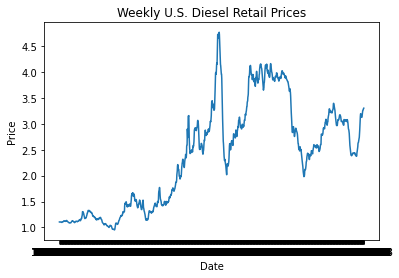

In [28]:
# Plot the data
plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Weekly U.S. Diesel Retail Prices')
plt.show()

In [29]:
df.drop('Date', axis=1, inplace=True)  # not needed anymore
data = df.values  # get the values as numpy array

def normalize(data, min, max):  # https://en.wikipedia.org/wiki/Feature_scaling
    data = data - min  # Take note that operations like - and / here are all element-wise across 2 lists. This is a Numpy array feature, NOT a python list feature. If you pass in data as a python list, it will give error!
    data = data / max
    return data

data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.03211587],
       [0.03232578],
       [0.03274559],
       [0.03253568],
       [0.03190596],
       [0.03211587],
       [0.03169605],
       [0.03106633],
       [0.03064652],
       [0.03064652]])

In [19]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    """
    Series: an iterable
    batch_size: number of samples per batch
    n_past: number of timesteps to look back (x or input to the model)
    n_future: number of timesteps to predict (y or output of the model)
    shift: number of timesteps to shift the window by, usually 1 if we want to maximize the use of data
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))  # taking the past as x, future as y, split by n_past
    return ds.batch(batch_size).prefetch(1)


batch_size = 32  # explore how changing this affects the model (hint: it is not as simple as larger batch size = better performance, like in image tasks!)
n_past = 10
n_future = 10
shift = 1  # usually we keep it 1

train_ds = windowed_dataset(series=train, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)
valid_ds = windowed_dataset(series=val, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)

In [20]:
# Model V1

xIn = Input((n_past, 1))  # 2D input, where first dimension is number of timesteps to look back, 2nd dimension is number of features or columns of data (yes you can input multiple time series at once). Remember that the batch size dimension is always omitted in Input() so don't be surprised if model.summary() tells you input is 3D.
x = LSTM(32, return_sequences=True)(xIn)  # LSTM layer with 32 cells. Return sequences = True is needed if you are connecting another RNN after this layer, since an RNN expects sequences as input. If return sequences is False, it only return the features of the last step.
x = LSTM(32)(x)  # return sequences is False by default so no need to specify it here
xOut = Dense(n_future)(x)  # dense layer with the same number of neurons as the number of timesteps to predict. Each neuron output the predicted price for a timestep in future.

model = Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')  # for numbers based time series tasks, it is the same as a regression problem, so we use mse or mae or any regression loss
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Model V2: LSTM that returns sequence to dense layer and dense layer gathers all the time axis features. You will realise that this actually perform a bit better than V1.

xIn = Input((n_past, 1))  # 2D input, where first dimension is number of timesteps to look back, 2nd dimension is number of features or columns of data (yes you can input multiple time series at once). Remember that the batch size dimension is always omitted in Input() so don't be surprised if model.summary() tells you input is 3D.
x = LSTM(32, return_sequences=True)(xIn)  # LSTM layer with 32 cells. Return sequences = True is needed if you are connecting another RNN after this layer, since an RNN expects sequences as input. If return sequences is False, it only return the features of the last step.
x = LSTM(32, return_sequences=True)(x)  # return sequences is False by default so no need to specify it here
x = Dense(32, activation='swish')(x)  # this dense layer receives a 2D input of (10, 32). We can choose to do a Flatten() or GlobalAvgPool2D() before of after this layer. Dense layers can accept 2D inputs and output as 2D but because our final output is supposed to be 1D (1 x 10), so we have to do Flatten or GlobalAvgPool2D() before that output layer.
x = Flatten()(x)  # flatten the output of the previous layer to 1D
x = Dense(64, activation='swish')(x)
xOut = Dense(n_future)(x)  # dense layer with the same number of neurons as the number of timesteps to predict. Each neuron output the predicted price for a timestep in future.

model = Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')  # for numbers based time series tasks, it is the same as a regression problem, so we use mse or mae or any regression loss
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 32)            4352      
                                                                 
 lstm_5 (LSTM)               (None, 10, 32)            8320      
                                                                 
 dense_3 (Dense)             (None, 10, 32)            1056      
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                20544     
                                                                 
 dense_5 (Dense)             (None, 10)                650 

In [72]:
model.fit(train_ds, epochs=100, validation_data=valid_ds)

Epoch 1/100
35/35 [==============================] - 4s 26ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 2/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0057 -

In [73]:
# Make some predictions
preds = model.predict(valid_ds)
preds[0]  # because our model predicts 10 steps into the future each time, we see a 1 x 10 array

array([0.26227793, 0.2520403 , 0.27244106, 0.2585061 , 0.2717826 ,
       0.26838017, 0.26698768, 0.2724566 , 0.2791304 , 0.28045622],
      dtype=float32)

In [74]:
def unnormalize(data, min, max):  # https://en.wikipedia.org/wiki/Feature_scaling
    data = data * max
    data = data + min
    return data

preds_unnormed = unnormalize(preds, data.min(axis=0), data.max(axis=0))  # remember when we did normalization we used entire data's min and max so here we also need to
preds_unnormed[0]

array([2.20249206, 2.15371997, 2.25090921, 2.18452301, 2.24777234,
       2.23156311, 2.22492931, 2.25098318, 2.28277722, 2.28909341])

In [75]:
print(preds_unnormed.shape)
''''
(266, 10) means that we have 266 predictions, each is 10 steps into the future. E.g. the model is given 266 samples of input, and for each of them, it output the next 10 timesteps of prediction. However, because our shift size is 1, there will be an overlap of results. E.g. ABCDE -> FGHIJ, BCDEF -> GHIJK. You can see here that GHIJ is repeated. Therefore, we can only take the first timestep predicted and ignore the rest. E.g. we take F from 1st prediction, G from 2nd and so on. Btw, G in 1st pred may NOT be same value as G in 2nd pred because the model is receiving different input each time which affects ALL of its outputs. Here I use the same letter for simplicity’s sake but take note in real data it will likely to be slightly different.
'''
print(preds_unnormed[:, 0])  # to select the first element (first predicted timestep in this context), we use [:, 0]. This is how to access multiple dimension numpy arrays. The first : means take all values from the first dimension, the 0 means take only the 0th value in the 2nd dimension. This give us a 1D array of length 266.
print(preds_unnormed[:, 0].shape)  # (266,)

(266, 10)
[2.20249206 2.25588924 2.30713061 2.3477557  2.38083976 2.40317919
 2.42675369 2.4478102  2.47077135 2.51632579 2.5677567  2.61577801
 2.65242388 2.6751147  2.68757685 2.68771016 2.68816208 2.67150931
 2.64313538 2.61525865 2.58113049 2.54679106 2.5281212  2.52570359
 2.53963052 2.5638276  2.59014029 2.61390006 2.6301022  2.64078734
 2.64700585 2.64994508 2.66691816 2.69153733 2.70648068 2.70592228
 2.68994263 2.66933633 2.65224825 2.6587456  2.68619298 2.72405362
 2.77049797 2.81273296 2.83655847 2.83673254 2.81777063 2.80363811
 2.7855312  2.773425   2.76318964 2.7657701  2.76911709 2.76617076
 2.75941515 2.75615348 2.7586797  2.76801548 2.78013617 2.79052656
 2.79576897 2.79057469 2.77687805 2.75956849 2.74351813 2.72813933
 2.710814   2.69357528 2.67843685 2.66688791 2.65957476 2.66286496
 2.69412673 2.74127956 2.78533655 2.81914853 2.85859222 2.91366999
 2.97083143 3.01827162 3.04925568 3.06209151 3.06732114 3.0587404
 3.03444352 3.00530517 3.02615497 3.06588574 3.103088

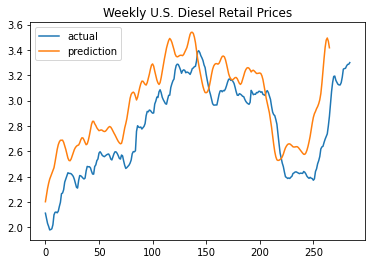

In [76]:
# Plot the predictions
plt.plot(unnormalize(val, data.min(axis=0), data.max(axis=0)), label='actual')  # our val was taken as subset of the normaized data so we need to unnormalize it here
plt.plot(preds_unnormed[:, 0], label='prediction')
plt.legend()
plt.title('Weekly U.S. Diesel Retail Prices')
plt.show()